# 09 Hyper-parameter search for Deep Q Learning

#### 👉Deep RL is hard, because (among other things) it's very sensitivity to the hyper-parameters.

#### 👉We tune the hyper-parmeters following a trial&error approach:

![](../images/hparams_search_diagram.svg)

#### 👉However, Hyper-parameter spaces in deep RL problems are HUGE. A brute-force solution that would try all possible combinations of hyper-parameters is not feasible. We need something smarter than that...

#### 👉And this is when Bayesian search methods enther into the picture.

#### 👉In a nutshell, Bayesian search methods use past searches to inform promising avenues.

#### 👉 [Optuna](https://optuna.readthedocs.io/en/stable/index.html) is a Python open-source library that implements Bayesian search methods

<img src="https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/optuna.png?raw=True" width="400"/>

#### 👉Hyper-paramater search a piece of cake 🍰if you use Optuna.

In [11]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Environment 🌎

In [12]:
import gym
env = gym.make('CartPole-v1')

### MLflow is a useful tool to track experiment results

cd to the root directory of this lesson (in my case `/Users/paulabartabajo/src/online-courses/hands-on-rl/03_cart_pole`) and spin up the mlflow tracking server as follows:

**$ mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000**

### 💡 if you have another service listening to port 5000, increase port number by 1 until you hit a free port.

In [13]:
import mlflow

# connect mlflow client to the mlflow server that runs on localhost:5000
MLFLOW_SERVER_URI = 'http://localhost:5000'
mlflow.set_tracking_uri(str(MLFLOW_SERVER_URI))

EXPERIMENT_NAME = 'hyperparameter_search'
mlflow.set_experiment(EXPERIMENT_NAME)

2022/03/10 21:02:08 INFO mlflow.tracking.fluent: Experiment with name 'hyperparameter_search' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/an21709/Data/lapadula-git/AI-ML/external/ReinforcementLearningOnTDS/AnthonyLapadula-fork/hands-on-rl/03_cart_pole/mlflow_runs/0', experiment_id='0', lifecycle_stage='active', name='hyperparameter_search', tags={}>

## Create an Optuna study

In [14]:
import optuna

from src.config import OPTUNA_DB

study = optuna.create_study(
    study_name=EXPERIMENT_NAME,
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{OPTUNA_DB}'
)

[I 2022-03-14 12:21:34,744] Using an existing study with name 'hyperparameter_search' instead of creating a new one.


## Objective function we want to maximize

In [15]:
from src.optimize_hyperparameters import objective

# we define a lambda function because study.optimize()
# expect the objective function to have only 1 input
# (trial), while our objective function hast 2 extra
# inputs I defined to add flexibility to the script
func = lambda trial: objective(trial,
                               force_linear_model=False,
                               n_episodes_to_train=200)

## Set threshold to terminate hyperparameter search

In [6]:
class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()

# Stop hyperparameter search when we hit a perfect mean reward of 500
hyperparam_search_stop_callback = CheckHyperparamMeanRewardThreshold(500.0)

## Let's start the search

In [7]:
study.optimize(func, n_trials=1000, callbacks=[hyperparam_search_stop_callback])

/home/an21709/Data/lapadula-git/AI-ML/pyenvs/ai-ml-venv/lib/python3.8/site-packages/optuna/distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/an21709/Data/lapadula-git/AI-ML/pyenvs/ai-ml-venv/lib/python3.8/site-packages/optuna/distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)


67,586 parameters


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:13<00:00,  2.73it/s]


Reward mean: 434.73, std: 84.36
Num steps mean: 434.73, std: 84.36


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:59<00:00,  2.39it/s]
[I 2022-03-14 12:30:46,908] Trial 116 finished with value: 450.05 and parameters: {'learning_rate': 0.0012796567720698411, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 50000, 'freq_steps_train': 8, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.07665766059316274, 'steps_epsilon_decay': 1000, 'seed': 288152315}. Best is trial 115 with value: 500.0.
/home/an21709/Data/lapadula-git/AI-ML/pyenvs/ai-ml-venv/lib/python3.8/site-packages/optuna/distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)


67,586 parameters


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:47<00:00,  1.87it/s]


Reward mean: 500.00, std: 0.00
Num steps mean: 500.00, std: 0.00


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:01<00:00,  1.85it/s]
[I 2022-03-14 12:41:36,603] Trial 117 finished with value: 500.0 and parameters: {'learning_rate': 0.001286765951302415, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 50000, 'freq_steps_train': 8, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.07447281469821579, 'steps_epsilon_decay': 1000, 'seed': 285615952}. Best is trial 115 with value: 500.0.


Stopping hyperparameter search because trial.value (500.0) hit threshold (500.0)


## These are the best hyper-parameters

In [8]:
best_trial = study.best_trial

hparams = {k: best_trial.params[k] for k in best_trial.params if k != 'seed'}
#hparams['nn_hidden_layers'] = eval(hparams['nn_hidden_layers']) 
print(hparams)

SEED = best_trial.params['seed']
print('Seed: ', SEED)

{'batch_size': 128, 'discount_factor': 0.9, 'epsilon_end': 0.07949712364861757, 'epsilon_start': 0.9, 'freq_steps_train': 8, 'freq_steps_update_target': 10, 'learning_rate': 0.0007460398004036752, 'max_grad_norm': 1, 'memory_size': 50000, 'n_gradient_steps': 1, 'n_steps_warm_up_memory': 1000, 'nn_hidden_layers': [256, 256], 'normalize_state': True, 'steps_epsilon_decay': 1000}
Seed:  291248385


## We can re-run the training to get the perfect agent

In [9]:
from src.utils import set_seed
set_seed(env, SEED)

from src.q_agent import QAgent
agent = QAgent(env, **hparams)

from src.loops import train
train(agent, env, n_episodes=200)

67,586 parameters


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.69it/s]

Reward mean: 489.28, std: 22.75
Num steps mean: 489.28, std: 22.75


## or simply load the `agent_id` from the best run

In [13]:
from src.q_agent import QAgent
from src.config import SAVED_AGENTS_DIR

# you can find the agent_id for the best run in the MLflow
# dashboard.
# 298 is the value in my case, but you need to check what is your
agent_id = 1124#298

path_to_saved_model = SAVED_AGENTS_DIR / 'CartPole-v1' / str(agent_id)
agent = QAgent.load_from_disk(env, path_to_saved_model)

67,586 parameters


## Evaluate the agent ⏱️

In [14]:
from src.loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:01<00:00,  2.08it/s]


In [11]:
import numpy as np
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

Reward average 491.36, std 20.07


## Let's see how far we got in each attempt

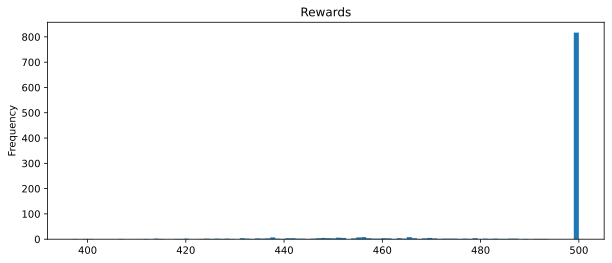

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

## Let's see our agent in action 🎬

In [49]:
# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

from src.viz import show_video

show_video(agent, env, sleep_sec=0.01, seed=123)